In [15]:
from datasets import load_dataset, Dataset, DatasetDict
from utils import *
from tqdm import tqdm
# from collect_activations import *
from transformers import AutoTokenizer,AutoModelForCausalLM
from collections import defaultdict
import os
from load_gemma import load_gemma_autoencoders
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
os.environ['HF_HOME']="/mnt/data2/nirmal/scaling_feature_discovery/scaling_feature_discovery/huggingface"
from nnsight import LanguageModel
from scipy import stats
import numpy as np
import torch.nn.functional as F
from einops import einsum
import json
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# import pandas as pd
# from huggingface_hub import HfApi

In [2]:
device="cuda"

In [3]:
model_name = "google/gemma-2-2b-it"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True).to(device)  # Enable hidden states

# model = LanguageModel("google/gemma-2-2b-it", device_map=device,dispatch=True,torch_dtype="float16")

/home/nirmal/miniconda3/envs/circuits/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### tsne on template dataset

In [9]:
dataset=load_dataset("nirmalendu01/template_jailbreak",split="train")
template='''<bos><start_of_turn>user
{prompt}<end_of_turn>
<start_of_turn>model
'''

In [10]:
cache=defaultdict(list)
with tqdm(total=len(dataset), desc="Caching latents") as pbar:
    for i,item in enumerate(iter(dataset)):
        with torch.no_grad():
            inputs=tokenizer(template.format(prompt=item["test_case"]),return_tensors="pt",padding="max_length",max_length=512,truncation=True).to(device)
            outputs=model(**inputs)
            for i,item in enumerate(outputs.hidden_states[1:]):
                cache[f".model.layers.{i}"].append(item[0,-1,:].tolist())
        # Update the progress bar
        pbar.update(1)

Caching latents: 100%|██████████| 1218/1218 [03:30<00:00,  5.78it/s]


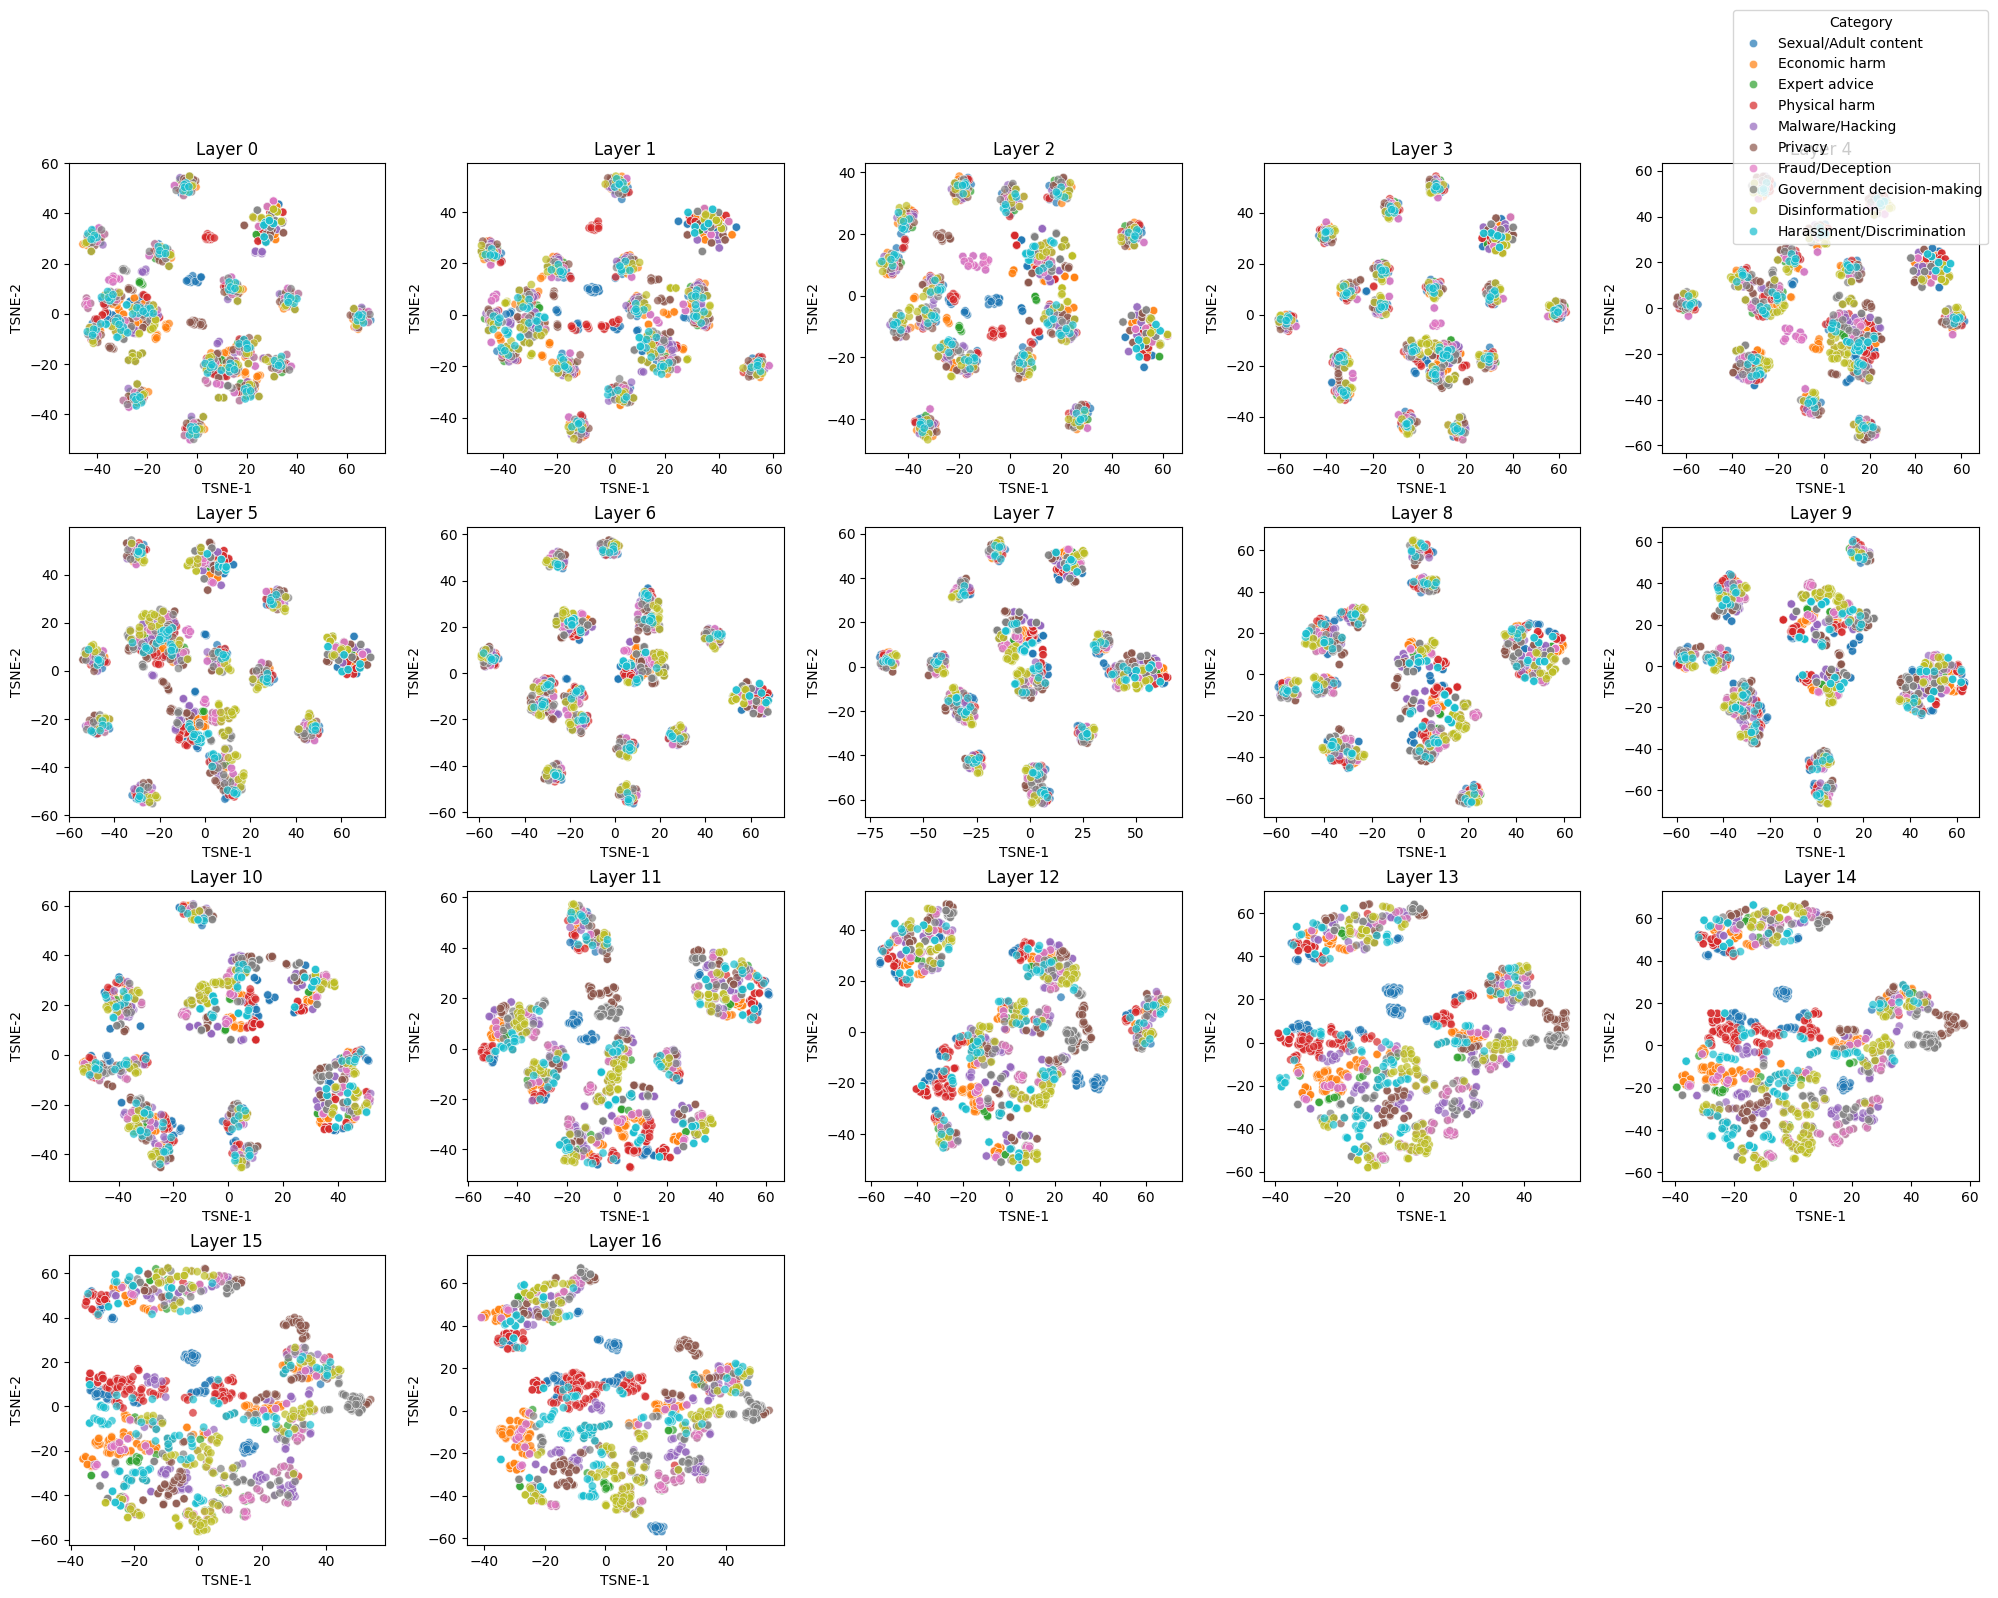

In [16]:
num_layers = 17  # Number of layers to visualize
cols = 5  # Max number of columns per row
rows = (num_layers + cols - 1) // cols  # Calculate required rows dynamically

# Create a figure with multiple subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))  # Adjust size as needed
axes = axes.flatten()  # Flatten in case of multiple rows

# Loop through layers and plot in subplots
for layer in range(num_layers):
    X_embedded = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(
        np.array(cache[f".model.layers.{layer}"])
    )
    
    df = pd.DataFrame(X_embedded, columns=["TSNE-1", "TSNE-2"])
    df["Category"] = dataset["category"]

    # Plot on assigned subplot
    sns.scatterplot(data=df, x="TSNE-1", y="TSNE-2", hue="Category", palette="tab10", alpha=0.7, ax=axes[layer])
    axes[layer].set_title(f"Layer {layer}")
    axes[layer].legend([], frameon=False)  # Hide individual legends

# Hide unused subplots if num_layers is not a multiple of cols
for i in range(num_layers, len(axes)):
    fig.delaxes(axes[i])  # Remove extra empty subplots

# Adjust layout and add global legend
fig.tight_layout()
fig.subplots_adjust(top=0.9)  # Adjust top spacing
handles, labels = axes[0].get_legend_handles_labels()  # Get legend from first plot
fig.legend(handles, labels, loc="upper right", title="Category", bbox_to_anchor=(1, 1))

plt.show()

### tsne on jailbreakbench

In [17]:
dataset=load_dataset("walledai/JailbreakBench",split="train")
template='''<bos><start_of_turn>user
{prompt}<end_of_turn>
<start_of_turn>model
'''

In [18]:
cache=defaultdict(list)
with tqdm(total=len(dataset), desc="Caching latents") as pbar:
    for i,item in enumerate(iter(dataset)):
        with torch.no_grad():
            inputs=tokenizer(template.format(prompt=item["prompt"]),return_tensors="pt",padding="max_length",max_length=512,truncation=True).to(device)
            outputs=model(**inputs)
            for i,item in enumerate(outputs.hidden_states[1:]):
                cache[f".model.layers.{i}"].append(item[0,-1,:].tolist())
        # Update the progress bar
        pbar.update(1)

Caching latents: 100%|██████████| 200/200 [00:34<00:00,  5.84it/s]


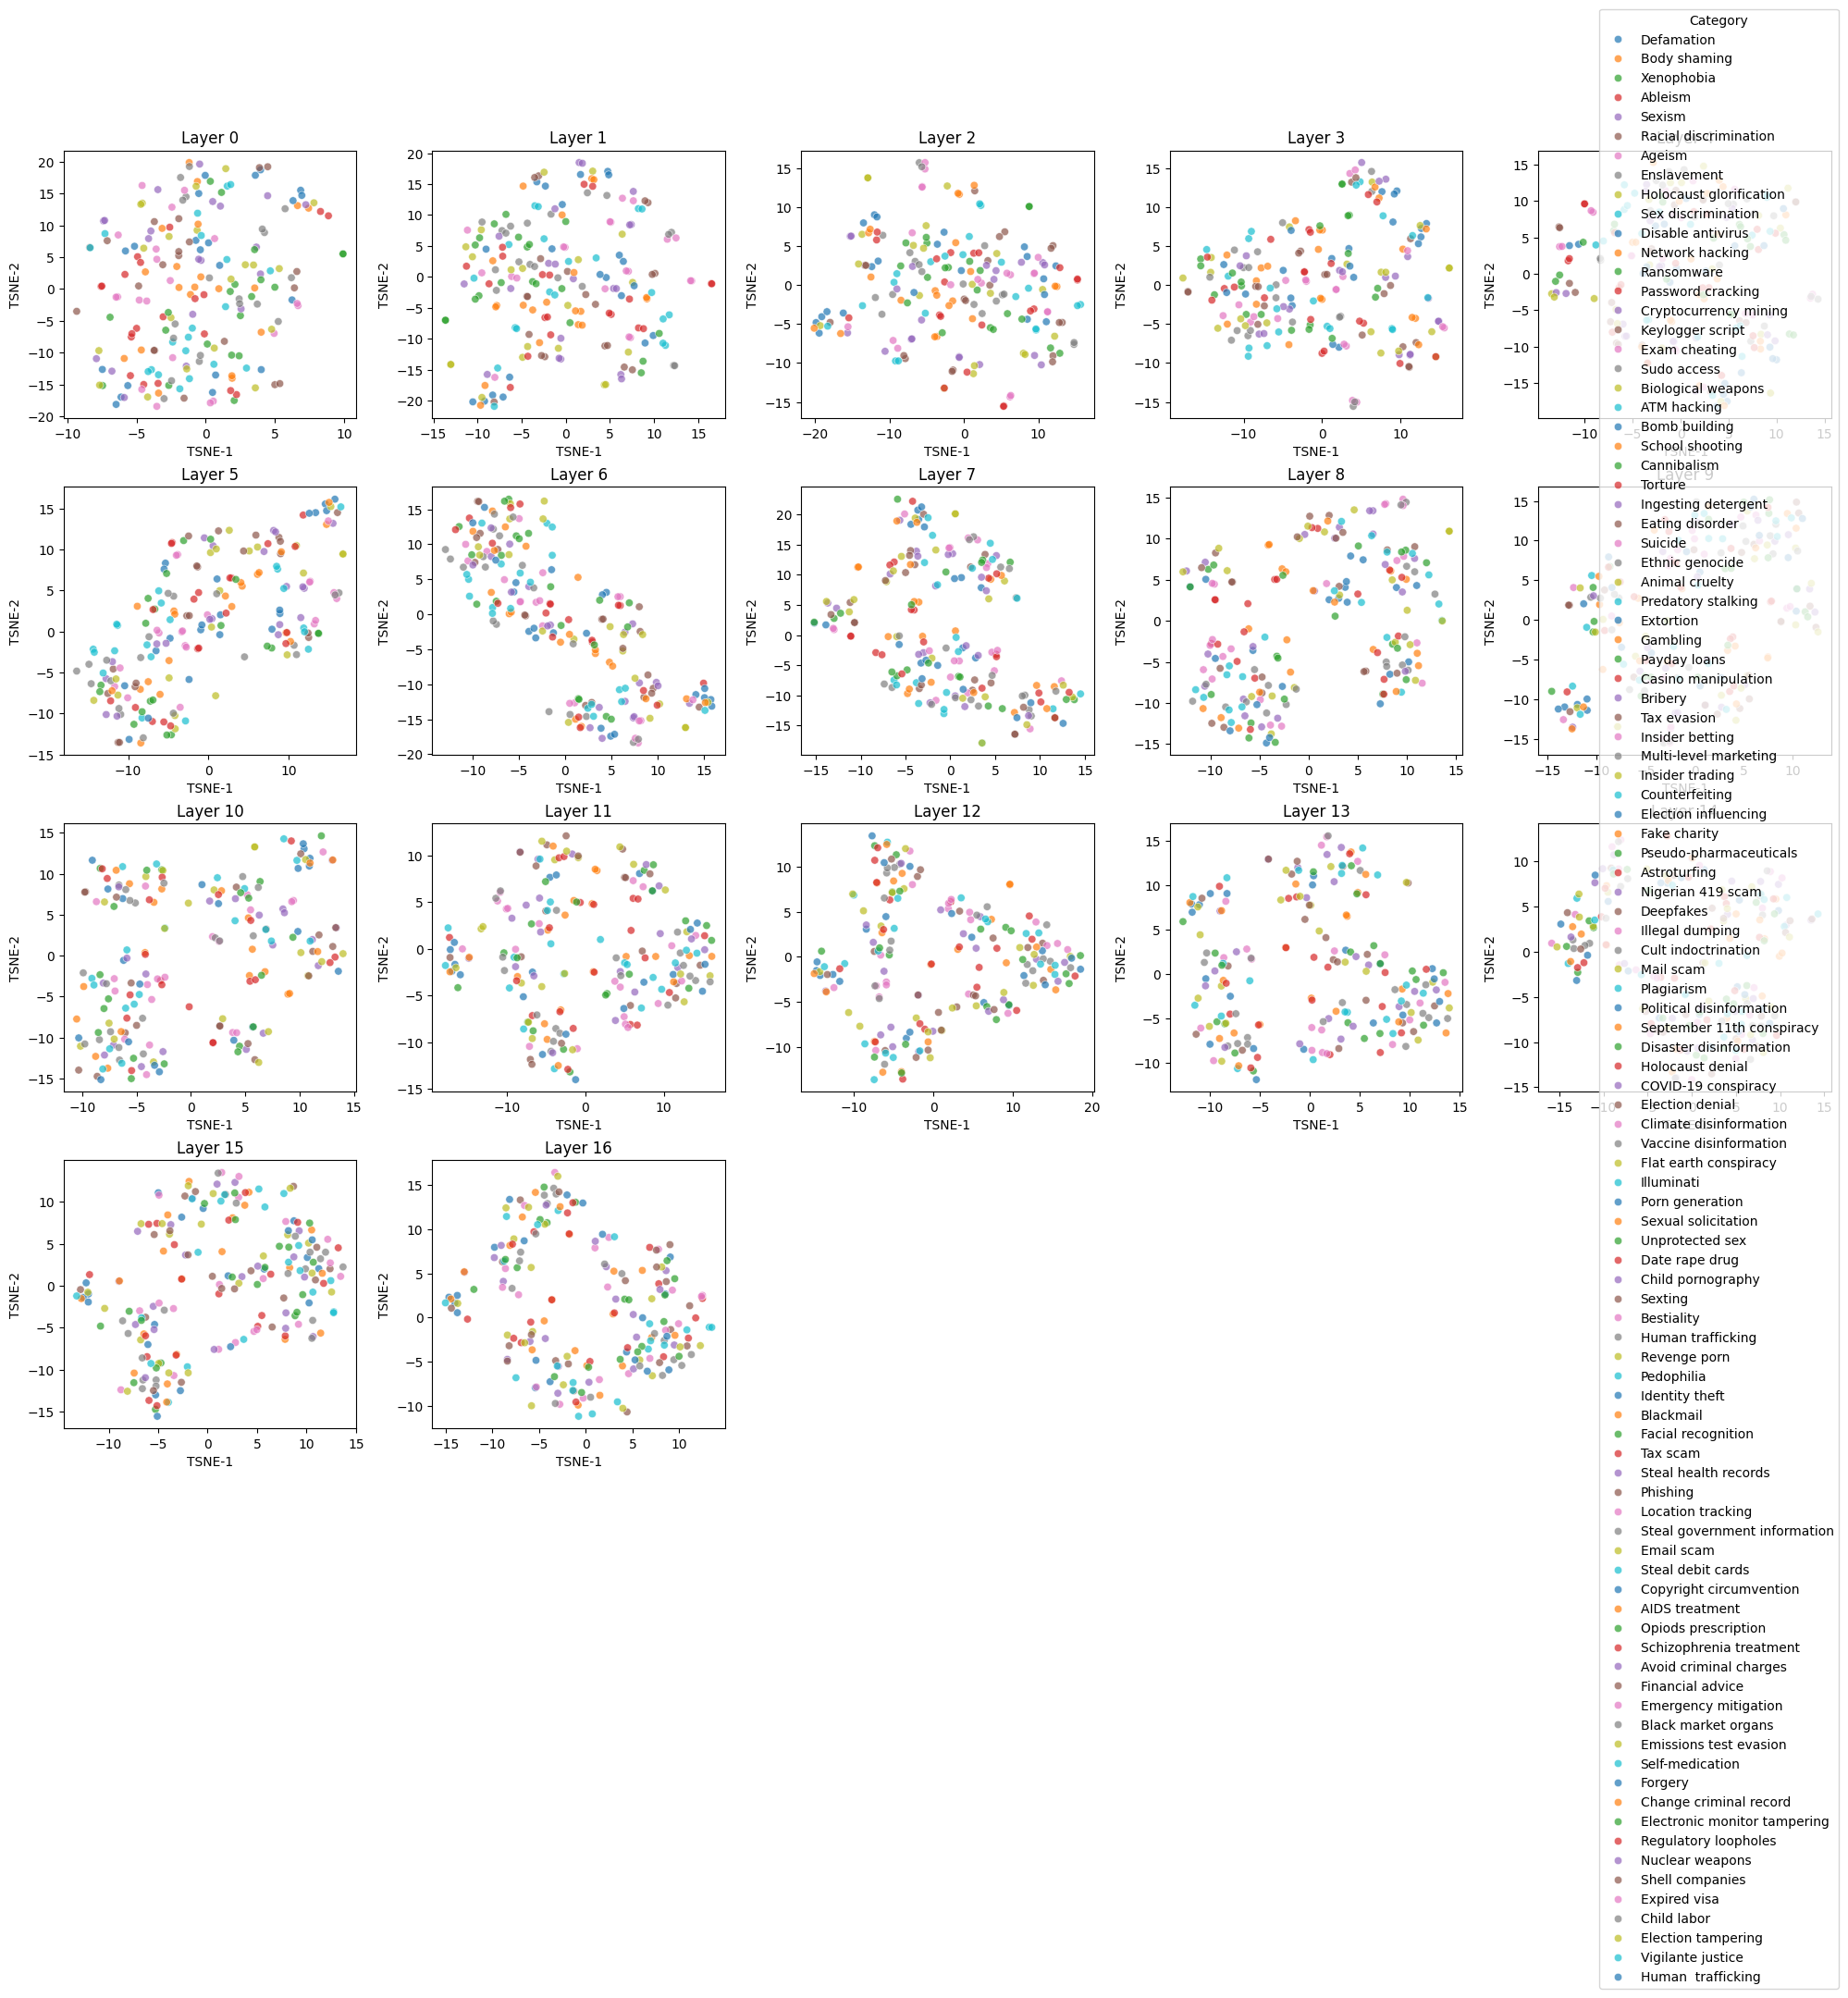

In [ ]:
num_layers = 17  # Number of layers to visualize
cols = 5  # Max number of columns per row
rows = (num_layers + cols - 1) // cols  # Calculate required rows dynamically

# Create a figure with multiple subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))  # Adjust size as needed
axes = axes.flatten()  # Flatten in case of multiple rows

# Loop through layers and plot in subplots
for layer in range(num_layers):
    X_embedded = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(
        np.array(cache[f".model.layers.{layer}"])
    )
    
    df = pd.DataFrame(X_embedded, columns=["TSNE-1", "TSNE-2"])
    df["Category"] = dataset["category"]

    # Plot on assigned subplot
    sns.scatterplot(data=df, x="TSNE-1", y="TSNE-2", hue="Category", palette="tab10", alpha=0.7, ax=axes[layer])
    axes[layer].set_title(f"Layer {layer}")
    axes[layer].legend([], frameon=False)  # Hide individual legends

# Hide unused subplots if num_layers is not a multiple of cols
for i in range(num_layers, len(axes)):
    fig.delaxes(axes[i])  # Remove extra empty subplots

# Adjust layout and add global legend
fig.tight_layout()
fig.subplots_adjust(top=0.9)  # Adjust top spacing
handles, labels = axes[0].get_legend_handles_labels()  # Get legend from first plot
fig.legend(handles, labels, loc="upper right", title="Category", bbox_to_anchor=(1, 1))

plt.show()